### Tools for reading the data

In [18]:
import h5py
import json
import numpy as np
import matplotlib.pyplot as plt
import glob

from IPython.display import display, JSON, clear_output

In [19]:
from EventReader import EventReader
from EventReader import show_data
import pandas as pd

#### Check all available data

In [20]:
data_dir = '/data/xenon/acolijn/optosim/data'
show_data(data_dir)

Found 9 subdirectories
Subdirectories:
['logs', 'mc0000', 'mc0001', 'mc0002', 'mc0003', 'mc0004', 'mc0005', 'mc0006', 'mc9999']


,subdir,detector,nevents,nphoton_per_event,set_no_scatter,set_experimental_scatter_model,radius
0,mc0000,XAMS,1000,100000,False,True,3.2
1,mc0001,XAMS,10000,10000,False,True,3.2
2,mc0002,XAMS,10000,10000,True,True,3.2
3,mc0003,XAMS,10000,10000,False,False,3.2
4,mc0004,XAMS,10000,10000,False,True,3.2
5,mc0005,XAMS,10000,10000,True,True,3.2
6,mc0006,XAMS,10000,"[1000, 25000]",False,True,3.2
7,mc9999,XAMS,100,10000,False,True,8.0


#### Get all the file names and initialize the data reader class

In [21]:
files = glob.glob('/data/xenon/acolijn/optosim/data/mc0006/*0000.hd5f')
print(files)

['/data/xenon/acolijn/optosim/data/mc0006/mc0006.0000.hd5f']


#### Loop over the events

1. maximum number of events can be set with nmax
2. use plot=True to show the events 

Note: the event loop below assumes a 2x2 detector. For other dimensions the code needs to be adapted

In [22]:
plot=True
nmax=1000000

nphoton =  7977


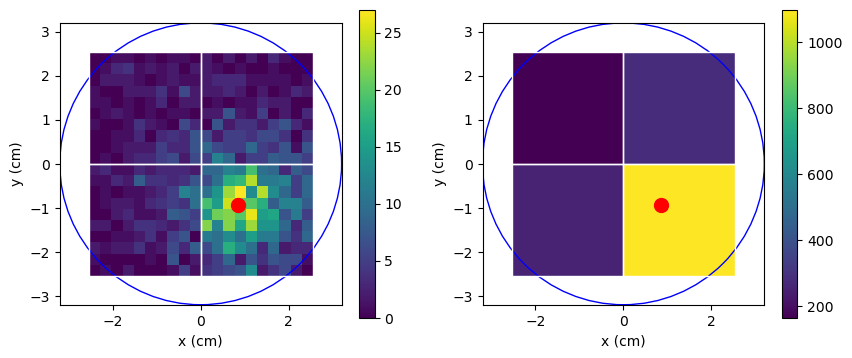

In [ ]:
%%time
events = EventReader(files)

n = 0

# this if where the data goes....
data_dict = { 
    'x': [],
    'y': [],
    'q_b': [],
    'q_l': [],
    'q_tot': []
}

#
# loop over evnts...
#
for ev in events:
    if n%1000 == 0:
        print('processed ',n,'events')#, events.print_event(ev))
    n+=1
    
    # if you want to show the events
    if plot:
        nph = ev['nphoton'][()]
        
        if nph < 2000000:
            print('nphoton = ',nph)

            events.show_event(ev)
            response = input("Press Enter to continue to the next event or 'q' to quit...")

            if response.lower() == 'q':
                print("Quit the event display......")
                break
        
            clear_output(wait=True)
    
    
    # retrieve the true hit position
    x_true = ev['true_position'][()]
    data_dict['x'].append(x_true[0])
    data_dict['y'].append(x_true[1])
    
    # get the data from the top PMT    
    pmt = ev['pmt_top'][()]
    qtot = float(np.sum(pmt))
    data_dict['q_b'].append((pmt[0][0] + pmt[1][0]))
    data_dict['q_l'].append((pmt[0][0] + pmt[0][1]))
    data_dict['q_tot'].append(qtot)
    
    if n>nmax:
        break
            
# write the data to a dataFrame
df = pd.DataFrame(data_dict)
df['r'] = np.sqrt(df['x']**2+df['y']**2)
df['q_tb'] = df['q_b']/df['q_tot']
df['q_lr'] = df['q_l']/df['q_tot']


events.reset()

#### Plot the charge ratio

Two plots: (i) $Q_L / Q_{tot}$ as a function of $x$ (ii) $Q_B / Q_{tot}$ as a function of $y$.

Text(0, 0.5, '$Q_B / Q_{tot}$')

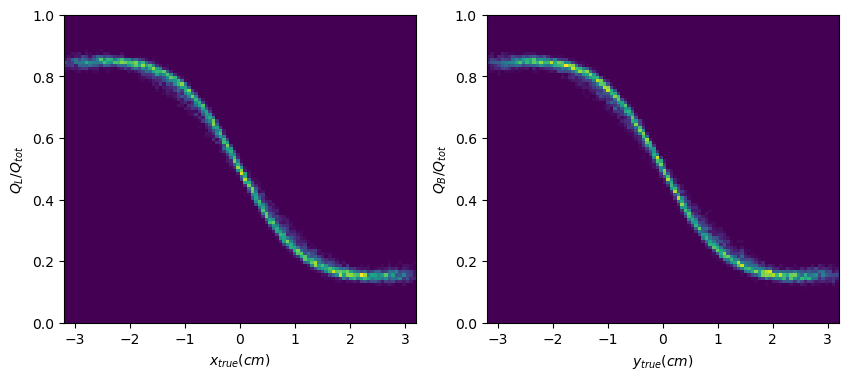

In [73]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

R = events.config['geometry']['radius']

h1 = axs[0].hist2d(df['x'],df['q_lr'],bins=(100,100), range=((-R,R),(0,1)))
axs[0].set_xlabel('$x_{true} (cm)$')
axs[0].set_ylabel('$Q_L / Q_{tot}$')

h2 = axs[1].hist2d(df['y'],df['q_tb'],bins=(100,100), range=((-R,R),(0,1)))
axs[1].set_xlabel('$y_{true} (cm)$')
axs[1].set_ylabel('$Q_B / Q_{tot}$')

Text(0, 0.5, '$Q_B$')

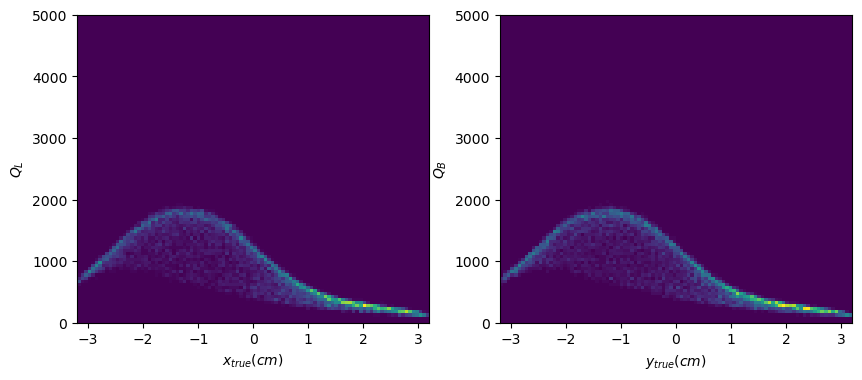

In [75]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

R = events.config['geometry']['radius']

h1 = axs[0].hist2d(df['x'],df['q_l'],bins=(100,100), range=((-R,R),(0,5000)))
axs[0].set_xlabel('$x_{true} (cm)$')
axs[0].set_ylabel('$Q_L$')

h2 = axs[1].hist2d(df['y'],df['q_b'],bins=(100,100), range=((-R,R),(0,5000)))
axs[1].set_xlabel('$y_{true} (cm)$')
axs[1].set_ylabel('$Q_B$')

.... and also $Q_{tot}$ as a function of radius.

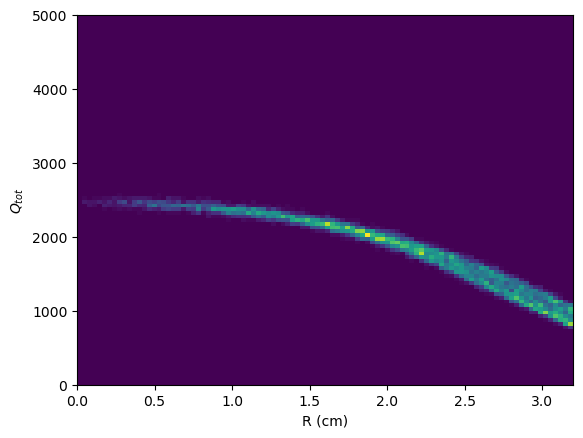

In [77]:
xp = np.array(xp)
yp = np.array(yp)
R = events.config['geometry']['radius']

r2 = np.sqrt(df['x']**2+df['y']**2)
h=plt.hist2d(r2,df['q_tot'],bins=100, range=((0,R),(0,5000)))
plt.xlabel('R (cm)')
plt.ylabel('$Q_{tot}$')
plt.show()